# <font color = brown>Ensemble-based Sentiment Analysis Using RNN and LSTM for Multiclss Classification: A Case Study on Airline Customer Feedback

---

# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, SimpleRNN, Dense, Dropout
from keras.optimizers import SGD
from wordcloud import WordCloud

# Import Dataset

In [2]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Dimension

In [3]:
df.shape

(14640, 15)

#### Information of Dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Data Cleaning
The `df.info()` method indicates that our dataset consists of 15 columns. For the purpose of this sentiment analysis, we will concentrate exclusively on two specific columns: 'text', which will serve as the input variable, and 'airline_sentiment', which will function as the output variable.

---

#### Data Preprocessing

In [5]:
df = df[['text', 'airline_sentiment']]

#### Define cleaning functions

In [6]:
# Removing emoji from text data

def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

In [7]:
#Removing punctuations, links, mentions and \r\n new line characters

def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    banned_list = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    return text.translate(table)

In [8]:
#Removing hastags '#' Symbol

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    return " ".join(word.strip() for word in re.split('#|_', new_tweet))

In [9]:
# Removing multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

#### Apply cleaning

In [10]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(clean_hashtags(strip_all_entities(strip_emoji(t)))))

Subsequently, we will create a new column titled 'cleaned_text' to store the processed and cleaned version of the text data. Additionally, we will rearrange the column order of our DataFrame to enhance clarity and organization.

In [11]:
df['cleaned_text'] = texts_new

# Rearranging the column order
df = df.reindex(columns=['text','cleaned_text', 'airline_sentiment'])
df

,text,cleaned_text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,what said,neutral
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,positive
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,neutral
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,negative
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,negative
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,thank you we got on a different flight to chicago,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,leaving over 20 minutes late flight no warning...,negative
14637,@AmericanAir Please bring American Airlines to...,please bring american airlines to blackberry10,neutral
14638,"@AmericanAir you have my money, you change my ...",you have my money you change my flight and don...,negative


## WordCloud Plots

In [12]:
from wordcloud import WordCloud

### Positive Words

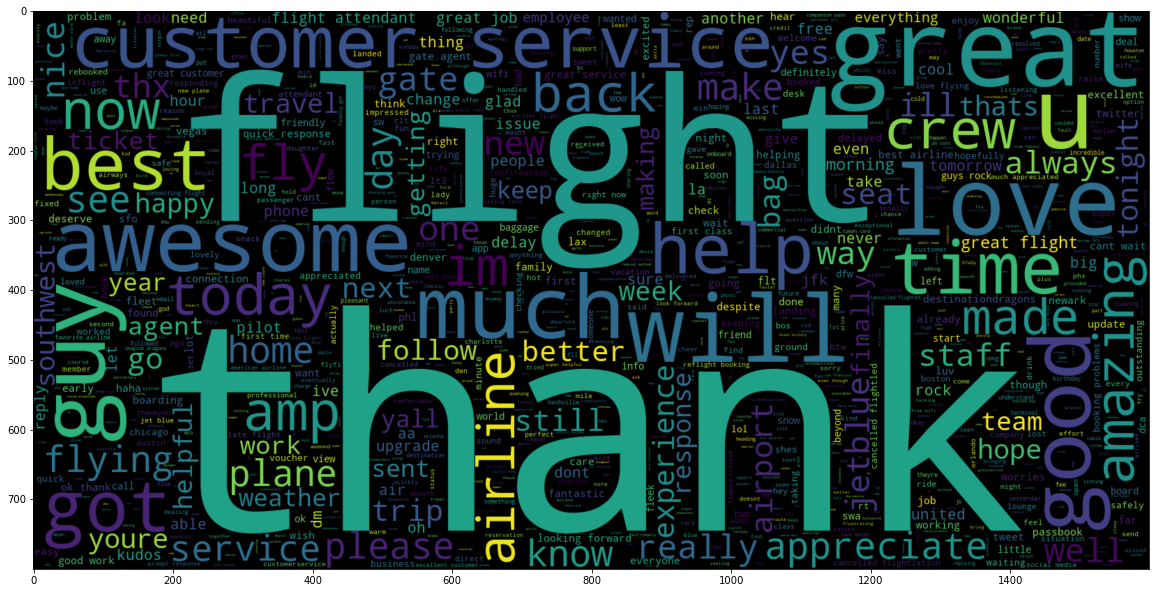

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.airline_sentiment == 'positive'].cleaned_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

### Neutral Words

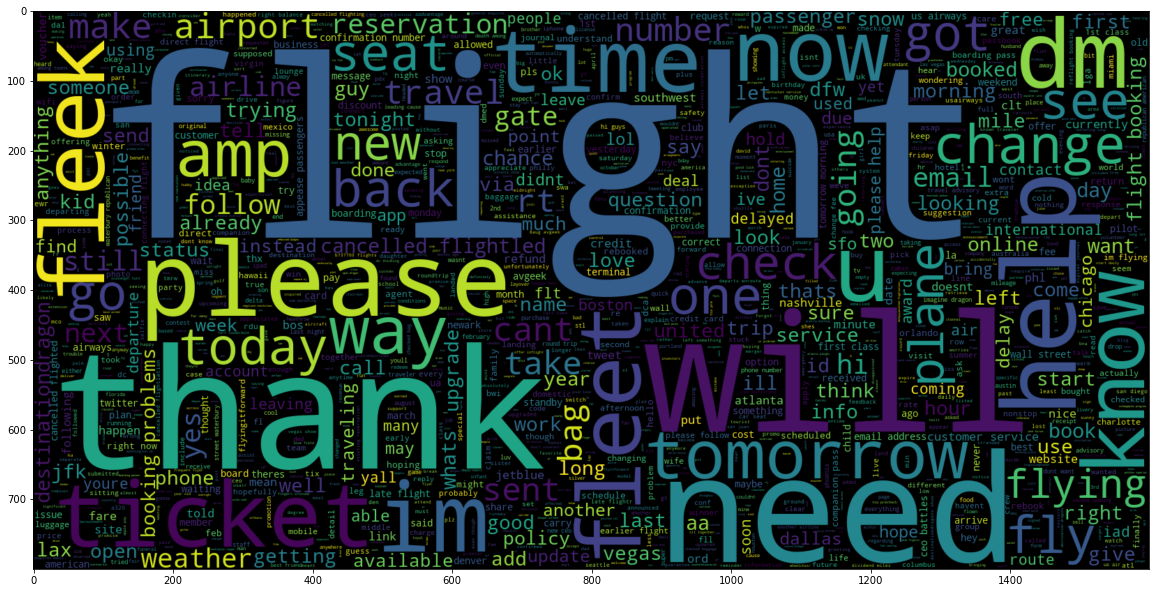

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.airline_sentiment == 'neutral'].cleaned_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

### Negative Words

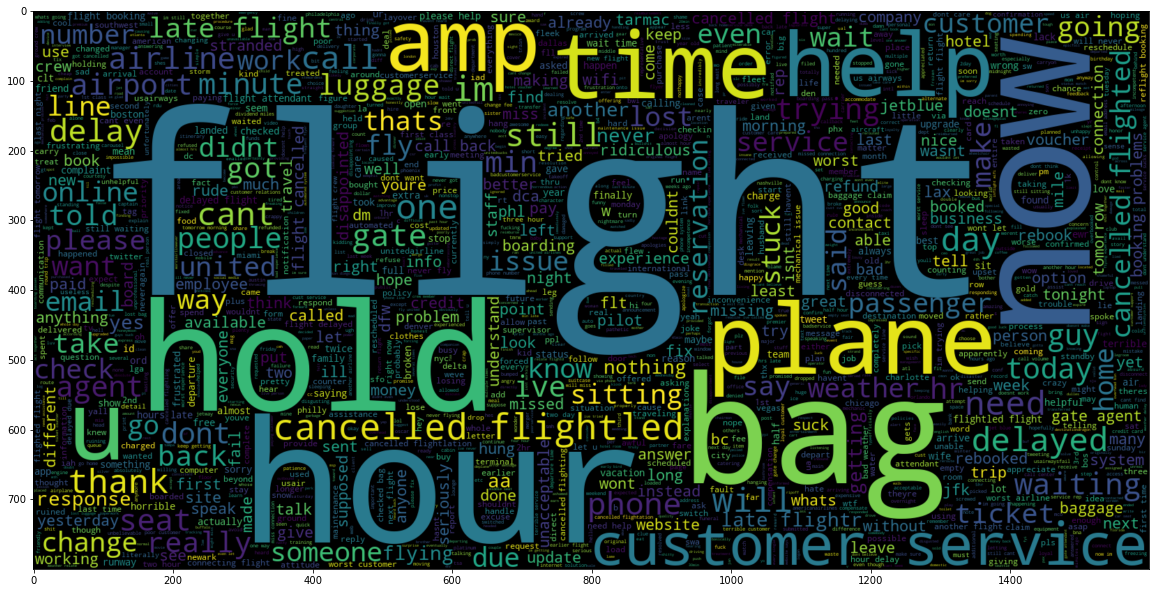

In [15]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.airline_sentiment == 'negative'].cleaned_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

### Tokenization and Padding

# Tokenization

To enable the processing of text data by the model, a tokenization process will be implemented. This process converts the text into a sequence of numerical representations, where each number corresponds to a specific word.

---

In [16]:
tokenizer = Tokenizer(num_words=512, lower=True, split=' ')
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])

In [17]:
token_lens = []

for token in X:
    token_lens.append(len(token))

In [18]:
df['cleaned_text'][4]

'and its a really big bad thing about it'

In [19]:
X[4]

[9, 59, 4, 126, 464, 203, 483, 75, 15]

In [20]:
print(np.max(token_lens))

29


# Padding

Given that the texts in the DataFrame vary in length, it is necessary to standardize their lengths through a process known as padding. Previously, we identified that the maximum number of tokens in any text is 29; therefore, we will utilize a value of 32 to ensure that all token sequences are uniform in length.

---

In [21]:
MAX_LEN = 32
X = pad_sequences(X, padding='post', maxlen=MAX_LEN)

# Label One-hot-encoding

One-hot encoding is a technique utilized in machine learning and data processing to represent categorical variables as binary vectors. This method is particularly important when working with categorical data.

In the context of multiclass classification models, one-hot encoding is essential, especially when employing the categorical cross-entropy loss function, which requires probability outputs for each class.

---

Initially, it is necessary to convert our labels into numerical values through a process known as encoding.

In [22]:
df['airline_sentiment'] = df['airline_sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df.head()

,text,cleaned_text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,what said,0
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,1
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,0
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,-1
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,-1


Then, one-hot-encoding.

In [23]:
y = pd.get_dummies(df['airline_sentiment'])
y.head().astype(int)

,-1,0,1
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0


This is how we transform our label.
- Negative -> -1-> [1 0 0]
- Neutral  -> 0 -> [0 1 0]
- Positive -> 1 -> [0 0 1]

# Data Split

Our dataset is divided into three segments: training, validation, and testing. The training and validation sets will be utilized for model training, while the testing set will be employed for evaluation purposes.

---

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify=y_train,test_size=0.25, random_state=1)


#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)


### Define Parameters

In [25]:
vocab_size = 5000
embedding_size = 64
epochs = 50
batch_size = 32
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

## RNN Model

In [26]:
rnn_model = Sequential([
    Embedding(vocab_size, embedding_size, input_length=MAX_LEN),
    SimpleRNN(64, return_sequences=True, activation='relu'),
    SimpleRNN(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 64)            320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32, 64)            8256      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 336,707
Trainable params: 336,707
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
#from keras.callbacks import EarlyStopping
rnn_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)


#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])


Epoch 1/50
275/275 [==============================] - 4s 16ms/step - loss: 0.9603 - accuracy: 0.6203 - val_loss: 0.9175 - val_accuracy: 0.6277
Epoch 2/50
275/275 [==============================] - 4s 14ms/step - loss: 0.9279 - accuracy: 0.6277 - val_loss: 0.9143 - val_accuracy: 0.6277
Epoch 3/50
275/275 [==============================] - 4s 14ms/step - loss: 0.9252 - accuracy: 0.6277 - val_loss: 0.9143 - val_accuracy: 0.6277
Epoch 4/50
275/275 [==============================] - 4s 13ms/step - loss: 0.9227 - accuracy: 0.6277 - val_loss: 0.9157 - val_accuracy: 0.6277
Epoch 5/50
275/275 [==============================] - 4s 13ms/step - loss: 0.9196 - accuracy: 0.6277 - val_loss: 0.9140 - val_accuracy: 0.6277
Epoch 6/50
275/275 [==============================] - 4s 16ms/step - loss: 0.9208 - accuracy: 0.6277 - val_loss: 0.9136 - val_accuracy: 0.6277
Epoch 7/50
275/275 [==============================] - 4s 16ms/step - loss: 0.9203 - accuracy: 0.6277 - val_loss: 0.9125 - val_accuracy: 0.6277

In [28]:
### Define Parameters

In [29]:
vocab_size = 5000
embedding_size = 32
epochs = 50
batch_size = 32
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

### LSTM Model

In [30]:
lstm_model = Sequential([
    Embedding(vocab_size, embedding_size, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 32)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 308,867
Trainable params: 308,867
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
lstm_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/50
275/275 [==============================] - 21s 77ms/step - loss: 0.8548 - accuracy: 0.6411 - val_loss: 0.8198 - val_accuracy: 0.6503
Epoch 2/50
275/275 [==============================] - 19s 69ms/step - loss: 0.7640 - accuracy: 0.6625 - val_loss: 0.7273 - val_accuracy: 0.7070
Epoch 3/50
275/275 [==============================] - 17s 63ms/step - loss: 0.6816 - accuracy: 0.7113 - val_loss: 0.6781 - val_accuracy: 0.7141
Epoch 4/50
275/275 [==============================] - 17s 60ms/step - loss: 0.6423 - accuracy: 0.7319 - val_loss: 0.6584 - val_accuracy: 0.7497
Epoch 5/50
275/275 [==============================] - 18s 64ms/step - loss: 0.6372 - accuracy: 0.7385 - val_loss: 0.7367 - val_accuracy: 0.6677
Epoch 6/50
275/275 [==============================] - 23s 83ms/step - loss: 0.6543 - accuracy: 0.7181 - val_loss: 0.6623 - val_accuracy: 0.7456
Epoch 7/50
275/275 [==============================] - 25s 90ms/step - loss: 0.6027 - accuracy: 0.7500 - val_loss: 0.6271 - val_accuracy:

### Plot Training Curves

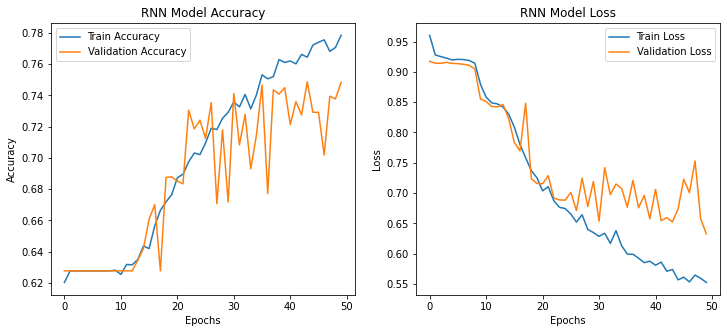

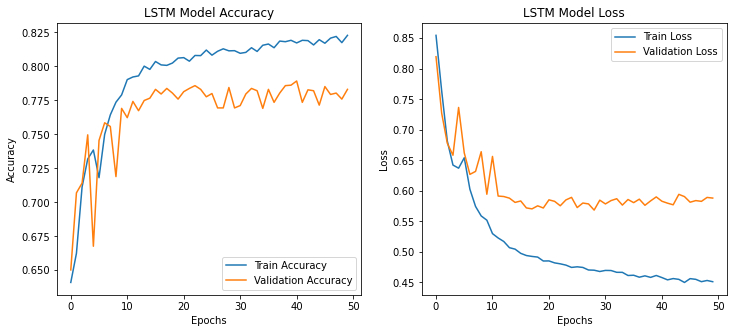

In [32]:
def plot_training(history, model_name):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training(rnn_history, "RNN Model")
plot_training(lstm_history, "LSTM Model")

### Confusion Matrix

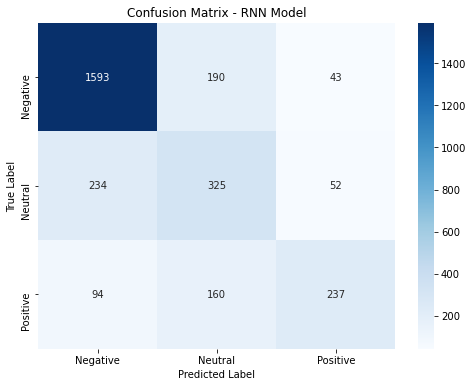

Classification Report - RNN Model:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1826
           1       0.48      0.53      0.51       611
           2       0.71      0.48      0.58       491

    accuracy                           0.74      2928
   macro avg       0.67      0.63      0.64      2928
weighted avg       0.74      0.74      0.73      2928



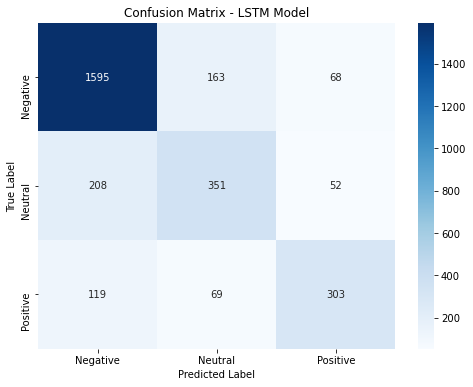

Classification Report - LSTM Model:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1826
           1       0.60      0.57      0.59       611
           2       0.72      0.62      0.66       491

    accuracy                           0.77      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.76      0.77      0.76      2928



In [33]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print(f"Classification Report - {model_name}:\n", classification_report(np.argmax(y_test.values, axis=1),
                                                                             np.argmax(y_pred, axis=1)))

plot_confusion_matrix(rnn_model, X_test, y_test, "RNN Model")
plot_confusion_matrix(lstm_model, X_test, y_test, "LSTM Model")

### Ensemble Predictions

In [34]:
rnn_predictions = rnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)
ensemble_predictions = (rnn_predictions + lstm_predictions) / 2
ensemble_pred_labels = np.argmax(ensemble_predictions, axis=1)
y_test_labels = np.argmax(y_test.values, axis=1)

### Evaluate Ensemble

In [35]:
ensemble_accuracy = accuracy_score(y_test_labels, ensemble_pred_labels)
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Classification Report:\n", classification_report(y_test_labels, ensemble_pred_labels))

Ensemble Model Accuracy: 0.7663934426229508
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1826
           1       0.59      0.55      0.57       611
           2       0.74      0.59      0.65       491

    accuracy                           0.77      2928
   macro avg       0.72      0.68      0.69      2928
weighted avg       0.76      0.77      0.76      2928



### Plot Ensemble Training Curve

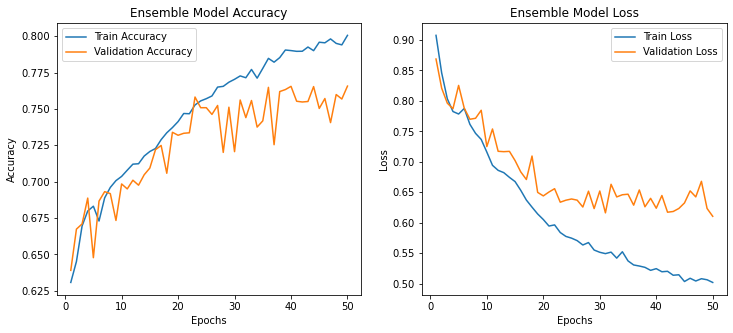

In [36]:
def plot_ensemble_training(rnn_history, lstm_history):
    epochs = range(1, len(rnn_history.history['accuracy']) + 1)
    train_acc = np.mean([rnn_history.history['accuracy'], lstm_history.history['accuracy']], axis=0)
    val_acc = np.mean([rnn_history.history['val_accuracy'], lstm_history.history['val_accuracy']], axis=0)
    train_loss = np.mean([rnn_history.history['loss'], lstm_history.history['loss']], axis=0)
    val_loss = np.mean([rnn_history.history['val_loss'], lstm_history.history['val_loss']], axis=0)
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Ensemble Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Ensemble Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_ensemble_training(rnn_history, lstm_history)

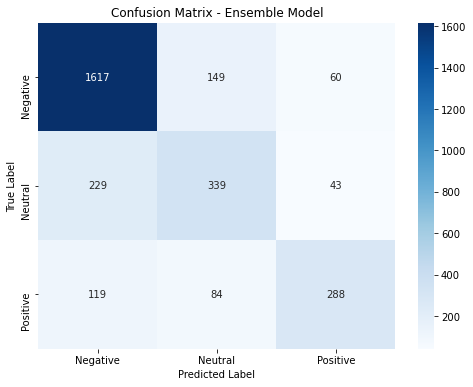

Ensemble Model Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.89      0.85      1826
     Neutral       0.59      0.55      0.57       611
    Positive       0.74      0.59      0.65       491

    accuracy                           0.77      2928
   macro avg       0.72      0.68      0.69      2928
weighted avg       0.76      0.77      0.76      2928



In [37]:
# Ensemble Confusion Matrix
def plot_ensemble_confusion_matrix(ensemble_pred_labels, y_test_labels):
    cm = confusion_matrix(y_test_labels, ensemble_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Confusion Matrix - Ensemble Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Ensemble Model Classification Report:\n", 
          classification_report(y_test_labels, ensemble_pred_labels, 
                                target_names=['Negative', 'Neutral', 'Positive']))

# Call the function
plot_ensemble_confusion_matrix(ensemble_pred_labels, y_test_labels)
